In [1]:
## Importing libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from windrose import WindroseAxes
import os
from scipy.stats import weibull_min

C:\Users\Pascal\AppData\Local\Temp\ipykernel_20264\3874732964.py:50: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  full_time_range = pd.date_range(start=Era5_data.index.min(), end=Era5_data.index.max(), freq='H')


Data Availability is 99.97%
Missing time periods are:
DatetimeIndex(['2023-02-26 00:00:00', '2023-02-26 01:00:00',
               '2023-02-26 02:00:00', '2023-02-26 03:00:00',
               '2023-02-26 04:00:00', '2023-02-26 05:00:00',
               '2023-02-26 06:00:00', '2023-02-26 07:00:00',
               '2023-02-26 08:00:00', '2023-02-26 09:00:00',
               '2023-02-26 10:00:00', '2023-02-26 11:00:00',
               '2023-02-26 12:00:00', '2023-02-26 13:00:00',
               '2023-02-26 14:00:00', '2023-02-26 15:00:00',
               '2023-02-26 16:00:00', '2023-02-26 17:00:00',
               '2023-02-26 18:00:00', '2023-02-26 19:00:00',
               '2023-02-26 20:00:00', '2023-02-26 21:00:00',
               '2023-02-26 22:00:00', '2023-02-26 23:00:00',
               '2023-02-27 00:00:00', '2023-02-27 01:00:00',
               '2023-02-27 02:00:00', '2023-02-27 03:00:00',
               '2023-02-27 04:00:00', '2023-02-27 05:00:00',
               '2023-02-27 06:0

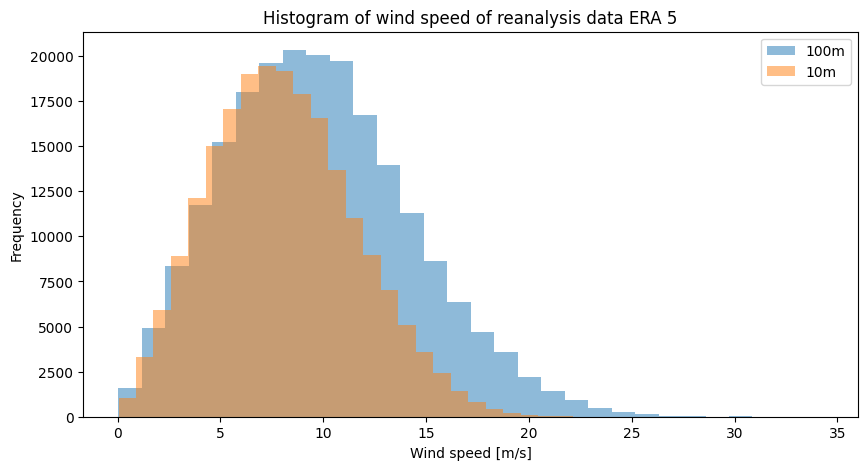

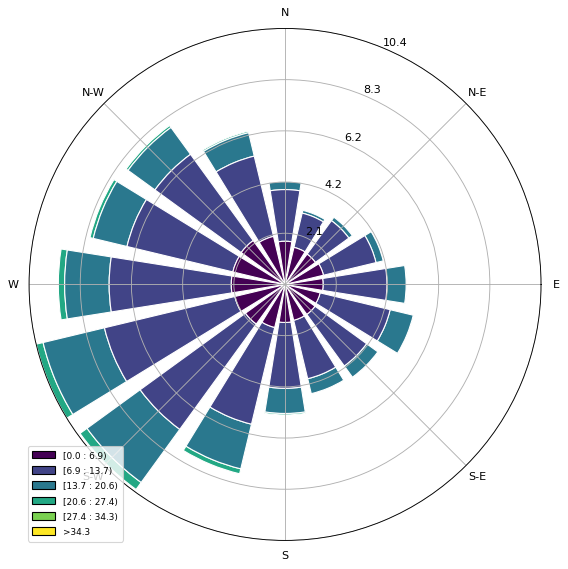

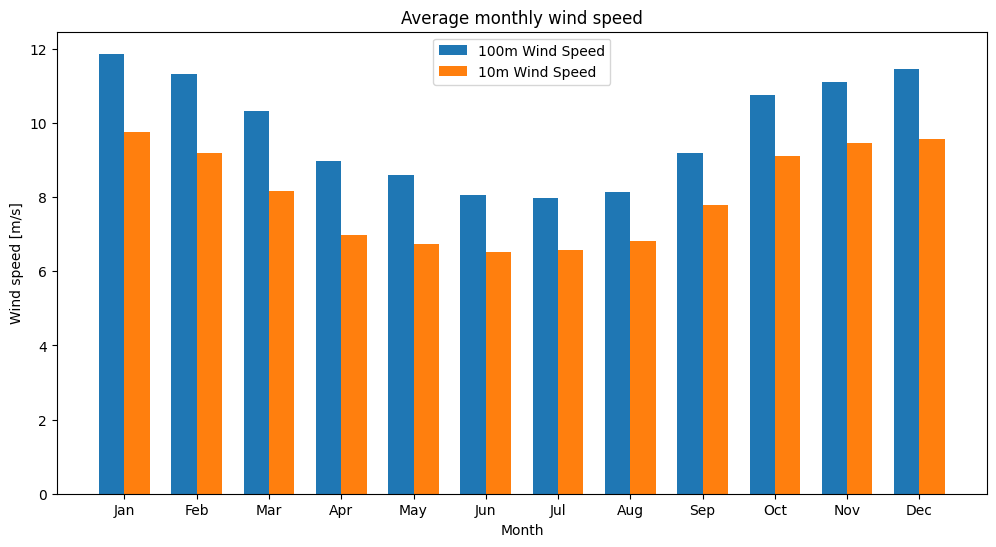

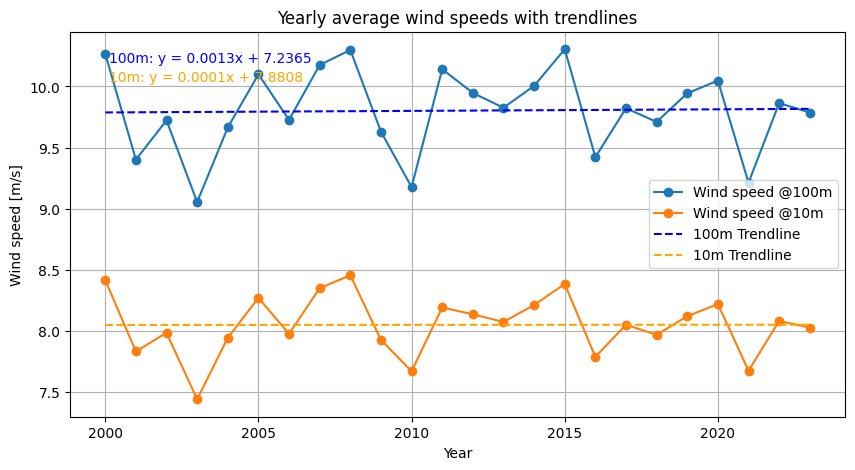


 The Average Wind Speeds over the whole period in m/s:
WS100    9.802337
WS10     8.051765
dtype: float64


In [2]:
# Function to load data from CSV files within the specified date range
def load_data(path, start_year, end_year):
    all_files = [f for f in os.listdir(path) if f.startswith('ERA5_N-9_') and f.endswith('.csv')]
    all_files.sort()
    Era5_data_list = []
    for file in all_files:
        year = int(file.split('_')[-1].split('.')[0])
        if start_year <= year <= end_year:
            Era5_data = pd.read_csv(os.path.join(path, file))
            Era5_data_list.append(Era5_data)
    return pd.concat(Era5_data_list, ignore_index=True)

# Function to calculate wind speed 
def calculate_wind_speed(Era5_data):
    Era5_data['WS100'] = np.sqrt(Era5_data['u100']**2 + Era5_data['v100']**2)
    Era5_data['WS10'] = np.sqrt(Era5_data['u10']**2 + Era5_data['v10']**2)
  
    return Era5_data

# Function to calculate wind direction
def calculate_wind_direction(Era5_data):
    Era5_data['WD100'] = (np.arctan2(Era5_data['u100'], Era5_data['v100']) * 180 / np.pi + 180) % 360 ## need to check with other
    Era5_data['WD10'] = (np.arctan2(Era5_data['u10'], Era5_data['v10']) * 180 / np.pi + 180) % 360
   
    return Era5_data

# Function to calculate yearly and monthly averages
def calculate_averages(Era5_data):
    Era5_data['time'] = pd.to_datetime(Era5_data['Time [UTC]'])
    Era5_data['year'] = Era5_data['time'].dt.year
    Era5_data['month'] = Era5_data['time'].dt.month
    
    yearly_avg = Era5_data.groupby('year')[['WS100', 'WS10']].mean()
    monthly_avg = Era5_data.groupby('month')[['WS100', 'WS10']].mean()
    overall_avg = Era5_data[['WS100', 'WS10']].mean()

    return yearly_avg, monthly_avg, overall_avg

# Function to check for data gaps
#def check_data_gaps(Era5_data):
    Era5_data['time_diff'] = Era5_data['time'].diff()
    gaps = Era5_data[Era5_data['time_diff'] > pd.Timedelta(hours=1)]
    return gaps

def check_data_gaps(Era5_data):
    Era5_data['time'] = pd.to_datetime(Era5_data['Time [UTC]'])
    Era5_data.set_index('time', inplace=True)
    
    # Generate a complete time range based on the data frequency
    full_time_range = pd.date_range(start=Era5_data.index.min(), end=Era5_data.index.max(), freq='H')
    Era5_data = Era5_data.reindex(full_time_range)
    
    missing_data = Era5_data[Era5_data.isnull().any(axis=1)]
    
    total_expected = len(full_time_range)
    total_actual = len(Era5_data.dropna())
    availability = (total_actual / total_expected) * 100
    
    print(f"Data Availability is {availability:.2f}%")
    
    if not missing_data.empty:
        print("Missing time periods are:")
        print(missing_data.index)
    else:
        print("No data gaps are found.")
    
    return missing_data

# Function to plot histograms
def plot_histogram(Era5_data):
    plt.figure(figsize=(10, 5))
    plt.hist(Era5_data['WS100'], bins=30, alpha=0.5, label='100m')
    plt.hist(Era5_data['WS10'], bins=30, alpha=0.5, label='10m')
    plt.xlabel('Wind speed [m/s]')
    plt.ylabel('Frequency')
    plt.title('Histogram of wind speed of reanalysis data ERA 5')
    plt.legend()
    plt.show()

def plot_wind_rose(Era5_data):
    ax = WindroseAxes.from_ax()
    ax.bar(Era5_data['WD100'], Era5_data['WS100'], normed=True, opening=0.8, edgecolor='white')
    ax.set_legend()
    plt.show()

# Function to plot yearly average wind speed with trendline
def plot_yearly_average_with_trendline(yearly_avg):
    years = yearly_avg.index
    WS100_year = yearly_avg['WS100']
    WS10_year = yearly_avg['WS10']
    
    # Calculate the trendline for 100m wind speed
    z_100m = np.polyfit(years, WS100_year, 1)
    p_100m = np.poly1d(z_100m)
    
    # Calculate the trendline for 10m wind speed
    z_10m = np.polyfit(years, WS10_year, 1)
    p_10m = np.poly1d(z_10m)
    
    plt.figure(figsize=(10, 5))
    
    # Plot the yearly average wind speeds
    plt.plot(years, WS100_year, marker='o', label='Wind speed @100m')
    plt.plot(years, WS10_year, marker='o', label='Wind speed @10m')
    
    # Plot the trendlines
    plt.plot(years, p_100m(years), linestyle='--', label='100m Trendline', color='blue')
    plt.plot(years, p_10m(years), linestyle='--', label='10m Trendline', color='orange')
    
    # Add trendline equations to the plot
    eq_100m = f'100m: y = {z_100m[0]:.4f}x + {z_100m[1]:.4f}'
    eq_10m = f'10m: y = {z_10m[0]:.4f}x + {z_10m[1]:.4f}'
    plt.text(0.05, 0.95, eq_100m, transform=plt.gca().transAxes, fontsize=10, verticalalignment='top', color='blue')
    plt.text(0.05, 0.90, eq_10m, transform=plt.gca().transAxes, fontsize=10, verticalalignment='top', color='orange')
    
    plt.xlabel('Year')
    plt.ylabel('Wind speed [m/s]')
    plt.title('Yearly average wind speeds with trendlines')
    plt.legend()
    plt.grid(True)
    plt.show()
    
def plot_monthly_average(monthly_avg):
    fig, ax = plt.subplots(figsize=(12, 6))

    months = monthly_avg.index
    WS100 = monthly_avg['WS100']
    WS10 = monthly_avg['WS10']

    width = 0.35  # Width of the bars

    ax.bar(months - width/2, WS100, width, label='100m Wind Speed')
    ax.bar(months + width/2, WS10, width, label='10m Wind Speed')

    ax.set_xlabel('Month')
    ax.set_ylabel('Wind speed [m/s]')
    ax.set_title('Average monthly wind speed')
    ax.set_xticks(months)
    ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    ax.legend()

    plt.show()

## Execution
Era5_path = 'data/reanalysis'  
start_year = 2000
end_year = 2023
    
Era5_data = load_data(Era5_path, start_year, end_year)
Era5_data = calculate_wind_speed(Era5_data)
Era5_data = calculate_wind_direction(Era5_data)
    
yearly_avg, monthly_avg, overall_avg = calculate_averages(Era5_data)
missing_data = check_data_gaps(Era5_data)   


plot_histogram(Era5_data)
plot_wind_rose(Era5_data)

plot_monthly_average(monthly_avg)
plot_yearly_average_with_trendline(yearly_avg)

print("\n The Average Wind Speeds over the whole period in m/s:")
print(overall_avg)
